In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
import pandas as pd
import codecs
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'AppleGothic' #Macでmatplotlib日本語化
#import matplotlib.finance as mpf

import mpl_finance as mpf
from matplotlib.dates import date2num

from sklearn.preprocessing import MinMaxScaler

In [3]:
#snssns..set_styleset_sty ('whitegrid')
%matplotlib inline

pd.set_option("display.max_columns", 200) # 表示カラムの最大値
pd.set_option('display.max_rows', 200) # 表示行数の最大値
pd.set_option('display.max_colwidth', 30)
pd.set_option("display.float_format", '{:.3f}'.format) # 小数点以下の有効数字

# jupyterの幅を自動調整
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### データ読み込み

In [4]:
# dataframeを初期化
data = pd.DataFrame()

yy_list = ['13', '14', '15', '16', '17']
#yy_list = ['17', '18']

for i in yy_list:
    with  codecs.open("../01.data/01.row/cfd_result_20" + i + ".csv",  "r", "Shift-JIS", "ignore") as file:
        d = pd.read_csv(file, header=2, parse_dates=True, dtype={'終値' : str} )
        # カラム名を設定
        d.columns = ['xxx', 'yyy', 
                    'trading_day', 'aaa','price_start', 'price_high',  'price_low', 'price_close', 'bbb',
                    'price_close_diff_N1', 'ccc', 'ddd', 'eee', 'fff']
        
        #  カラムを除外する
        d = d.drop(['xxx', 'yyy', 'aaa', 'bbb', 'price_close_diff_N1'  ,'ccc', 'ddd', 'eee', 'fff'], axis=1)
        d['trading_day'] = pd.to_datetime(d['trading_day'])

    d = d.set_index('trading_day')
    d = d.dropna(axis=0)
    d['price_start'] = d['price_start'].str.replace(',', '').astype(int)
    d['price_high'] = d['price_high'].str.replace(',', '').astype(int)
    d['price_low'] = d['price_low'].str.replace(',', '').astype(int)
    d['price_close'] = d['price_close'].str.replace(',', '').astype(int)
    #d['price_close_diff_N1'] = d['price_close_diff_N1'].str.replace(',',  '') #.astype(int)

    data = pd.concat([data, d])

data.head()

,price_start,price_high,price_low,price_close
trading_day,,,,
2013-01-02,10496,10823,10423,10823
2013-01-03,10863,10863,10712,10763
2013-01-04,10789,10823,10656,10760
2013-01-07,10780,10790,10542,10625
2013-01-08,10612,10612,10376,10431


### 曜日判定

In [5]:
data['wd'] = data.index.weekday_name

In [6]:
data = pd.concat([data, pd.get_dummies(data['wd'], prefix='wd')], axis=1, join_axes=[data.index])
data = data.drop(['wd'], axis=1)

### 上昇・下落判定

In [7]:
def create_up_flg(x):
    if x.price_close > x.price_start : 
        return 1
    else:
        return 0

In [8]:
def create_down_flg(x):
    if x.price_close < x.price_start : 
        return 1
    else:
        return 0

In [9]:
# 当日上昇フラグ
data['up_flg'] = data.apply(lambda x : create_up_flg(x), axis=1)
# 当日下落フラグ
data['down_flg'] = data.apply(lambda x : create_down_flg(x), axis=1)

In [10]:
# 直近5日間 上昇回数
data['up_cnt_rolling5'] = data['up_flg'].rolling(5).sum()

In [11]:
# ダミー変数化 
data = pd.concat([data, pd.get_dummies(data['up_cnt_rolling5'], prefix='up_cnt_rolling5')], axis=1, join_axes=[data.index])
data = data.drop(['up_cnt_rolling5'], axis=1)

### ローソク足

In [12]:
# 上ひげの長さを集計
def create_up_must_length(x):
    if x.up_flg ==1 :
        return x.price_high - x.price_close
    
    elif x.up_flg == 0 :
        return x.price_high - x.price_start
        

In [13]:
# 下ひげの長さを集計
def create_down_must_length(x):
    if x.up_flg ==1 :
        return x.price_start - x.price_low
    
    elif x.up_flg == 0 :
        return x.price_close - x.price_low
        

In [14]:
def create_box_length(x):
    return abs( x.price_close - x.price_start)

In [15]:
# 上ひげの長さ
data['up_must_length'] = data.apply(lambda x : create_up_must_length(x), axis=1)

# 下ひげの長さ
data['down_must_length'] = data.apply(lambda x : create_down_must_length(x), axis=1)

# 箱の長さ
data['box_length'] = data.apply(lambda x : create_box_length(x), axis=1)

### RCI
https://www.fxbroadnet.com/tech12.jsp  

RCIは、価格そのものを計算対象とせずに「時間」と「価格」それぞれに順位をつけ、両者にどれだけの相関関係があるのかを指標化したものです。

In [16]:
#  RCI
def RCI(seq, itv):
  def ord(seq, idx, itv):
    p = seq[idx]
    o = 1
    for i in range(itv - 1):
      if p < seq[i]:
        o += 1
    return o

  def d(seq, itv):
    sum = 0
    for i in range(itv - 1):
      sum += pow((i + 1) - ord(seq, i, itv), 2)
    return sum

  return (1 - 6 * d(seq, itv) / (itv * (itv ** 2 - 1))) * 100


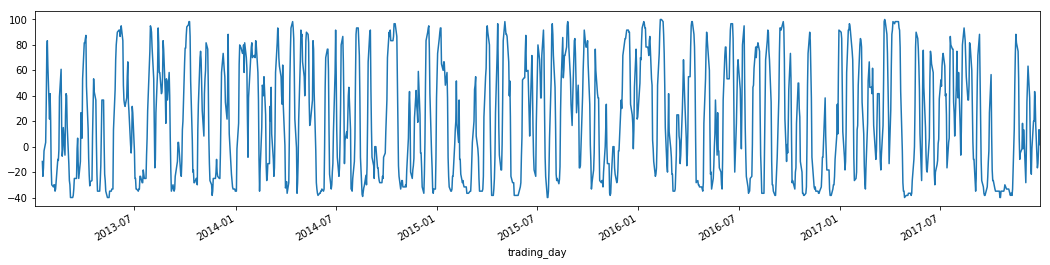

In [17]:
RCI_period = 9
RCI_list = []

for i in range(len(data)):
    if i- RCI_period + 1 >= 1 :
        # i - RCI_period + 1行目からi+1行目の終値を使ってRCI（期間：RCI_period）
        RCI_list.append( RCI( data[i - RCI_period + 1: i + 1 ].loc[:, 'price_close'],  RCI_period) )
         
    else :
        # 必要な期間の値がない場合はNANを代入
        RCI_list.append(np.nan)
        
data['RCI9'] = RCI_list
data['RCI9'].plot(figsize=(18,4))

In [18]:
#  正の値
def create_RCI9_p(x):
    if x.RCI9 >=0 :
        return x.RCI9
    else :
        return 0

#  負の値
def create_RCI9_m(x):
    if x.RCI9 <0 :
        return x.RCI9
    else :
        return 0

In [19]:
#  正の値
def create_RCI9_slope_p(x):
    if x.RCI9_slope >=0 :
        return x.RCI9_slope
    else :
        return 0

#  負の値
def create_RCI9_slope_m(x):
    if x.RCI9_slope <0 :
        return x.RCI9_slope
    else :
        return 0

In [20]:
# 上ひげの長さ
data['RCI9_p'] = data.apply(lambda x : create_RCI9_p(x), axis=1)
# 上ひげの長さ
data['RCI9_m'] = data.apply(lambda x : create_RCI9_m(x), axis=1)

In [21]:
#  RCIの傾き
data['RCI9_slope'] = data['RCI9'].diff(1)
# 　RCIの傾きが正のとき値を格納
data['RCI9_slope_p'] = data.apply(lambda x : create_RCI9_slope_p(x), axis=1)
# 　RCIの傾きが負のとき値を格納
data['RCI9_slope_m'] = data.apply(lambda x : create_RCI9_slope_m(x), axis=1)

### RSI
https://www.fxbroadnet.com/tech09.jsp  

RSI（The Relative Strength Index）は日本語で相対力指数と訳され、一定期間の値動きに対して上昇分の値動きが占める割合を算出し、価格の上昇の強さを数値化したチャートです。  
考案者は、テクニカル指標の父、米国のJ.W.ワイルダー。チャートの数値が一定の範囲（0～100など）で行ったり来たりする、いわゆるオシレーター指標の中でも、RSIは最もポピュラーなチャートの一つであり、FX取引でもよく使用されるチャートです。  

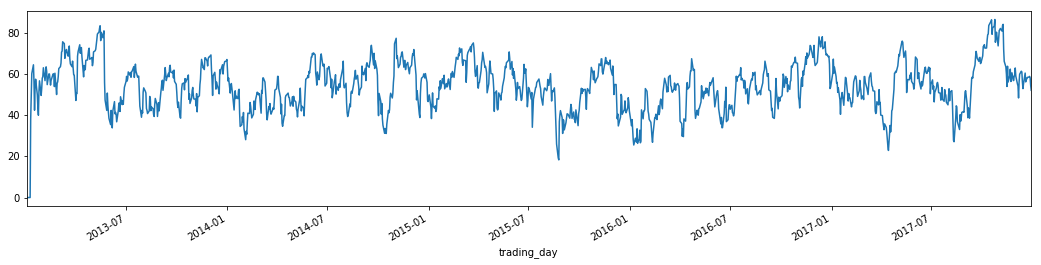

In [22]:
#RSI
RSI_period = 14
diff = data['price_close'].diff(1)
positive = diff.clip_lower(0).ewm(alpha=1/RSI_period).mean()
negative = diff.clip_upper(0).ewm(alpha=1/RSI_period).mean()
data['RSI'] = 100-100/(1-positive/negative)


data['RSI'].plot(figsize=(18,4))

In [23]:
# N-1の値との差分
data['RSI_slope'] = data['RSI'].diff(1)

## 移動平均
https://www.fxbroadnet.com/tech01.jsp  

移動平均線は、一定期間の平均価格を線でつなぎ、ジグザグした値動きのブレを慣らして価格トレンドの方向や強さを見るためのテクニカルチャートです。  
FXチャートに限らず、テクニカル分析の中で最もポピュラーで基本的な分析手法です。

移動平均には単純移動平均、加重移動平均、指数平滑移動平均など計算方法によって様々な種類がありますが、基本となる単純移動平均を例に説明します。

単純移動平均線（SMA,Simple Moving Average）は、計算の対象となる期間の複数の終値について平均値を算出し、期間をずらしながら線でつないで表示したものです。

たとえば20日移動平均（20SMA)であれば、本日を含めた過去20日間の終値を合計し、日数の20で割って平均した数値を１日ごとに計算して線でつなぎます。

In [24]:
data['MA25'] = data['price_close'].rolling(25).mean()
data['MA50'] = data['price_close'].rolling(50).mean()
data['MA75'] = data['price_close'].rolling(75).mean()

In [25]:
data['MA25_slope'] = data['MA25'].diff(1)
data['MA50_slope'] = data['MA50'].diff(1)
data['MA75_slope'] = data['MA75'].diff(1)

In [26]:
#  正の値
def create_X_p(x):
    if x >=0 :
        return x
    else :
        return 0

#  負の値
def create_X_m(x):
    if x <0 :
        return x
    else :
        return 0

In [27]:
# 移動平均の傾き（正負）
data['MA25_slope_p'] = data['MA25_slope'].apply(lambda x : create_X_p(x))
data['MA25_slope_m'] = data['MA25_slope'].apply(lambda x : create_X_m(x))
data['MA50_slope_p'] = data['MA50_slope'].apply(lambda x : create_X_p(x))
data['MA50_slope_m'] = data['MA50_slope'].apply(lambda x : create_X_m(x))
data['MA75_slope_p'] = data['MA75_slope'].apply(lambda x : create_X_p(x))
data['MA75_slope_m'] = data['MA75_slope'].apply(lambda x : create_X_m(x))

In [28]:
# ２５日移動平均線からの乖離率
def create_MA25_dev(x):
    return (x.price_close - x.MA25 ) / x.MA25

In [29]:
# 移動平均との乖離（正負）
data['MA25_dev'] = data.apply(lambda x : create_MA25_dev(x), axis=1)

data['MA25_dev_p'] = data['MA25_dev'].apply(lambda x : create_X_p(x))
data['MA25_dev_m'] = data['MA25_dev'].apply(lambda x : create_X_m(x))

### ゴールデンクロス・デッドクロス

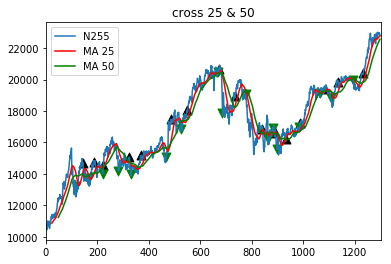

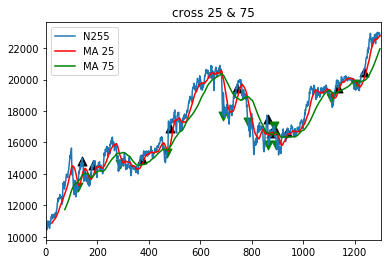

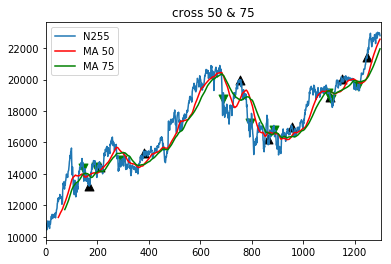

In [30]:
data = data.reset_index()
# [[短期, 長期], [短期, 長期] ・・・]
types = [[25, 50], [25, 75], [50, 75]]

for short_day, long_day in types:
 
    # 移動平均
    rolling_s  = data['price_close'].rolling(short_day).mean().fillna(0)
    rolling_l  = data['price_close'].rolling(long_day).mean().fillna(0)
 
    # 移動平均のクロス確認
    over_s_l  = rolling_s  > rolling_l
    golden = (over_s_l != over_s_l.shift(1)) & (over_s_l == True)
    dead   = (over_s_l != over_s_l.shift(1)) & (over_s_l == False)
 
    # 列 追加
    #   0：クロスなし
    #   1：ゴールデンクロス
    #  -1：デッドクロス
    col_name = 'cross_' + str(short_day) + '_' + str(long_day)
    data[col_name] = [x+y*-1 for x,y in zip(golden, dead)]
    data[col_name] = np.append(np.array([0] * (long_day+1)), data[col_name][long_day+1:])
    
    #
    # チャート描画
    #
    plt.plot(figsize = (18,5))
    plt.plot(range(len(data)), data['price_close'], label='N255')
    plt.plot(range(short_day-1, len(data)), rolling_s[short_day-1:], color='r', label='MA '+ str(short_day))
    plt.plot(range(long_day-1,  len(data)), rolling_l[long_day-1:],  color='g', label='MA '+ str(long_day))
    plt.legend(loc='upper left')
    plt.xlim(0, len(data)+1)
    
    #
    # ゴールデンクロス・デッドクロスのマークを描画する
    #
    crosses = data[data[col_name] != 0]
    
    golden_x = []
    golden_y = []
    golden_day = []
    dead_x = []
    dead_y = []
    dead_day = []
    
    for i in range(len(crosses)):
        if (crosses.iloc[i][col_name] == 1):
            golden_x.append(crosses.index[i])
            golden_y.append(crosses.iloc[i]['price_close'])
            golden_day.append(crosses.iloc[i]['trading_day'])
        else:
            dead_x.append(crosses.index[i])
            dead_y.append(crosses.iloc[i]['price_close'])
            dead_day.append(crosses.iloc[i]['trading_day'])
 
    plt.scatter(golden_x, golden_y, c='black', s=80, marker='^')
    plt.scatter(dead_x,   dead_y,   c='green', s=80, marker='v')
    
    """
    for i in range(len(golden_x)):
        plt.text(golden_x[i], golden_y[i]+500, '{0}-{1}'.format(int(golden_day[i][-5:-3]),int(golden_day[i][-2:])), ha = 'center', va = 'bottom')
    
    for i in range(len(dead_x)):
        plt.text(dead_x[i], dead_y[i]-500, '{0}-{1}'.format(int(dead_day[i][-5:-3]),int(dead_day[i][-2:])), ha = 'center', va = 'top', color='red')
 
    """
    plt.title('cross ' +  str(short_day) + ' & ' + str(long_day))
    plt.show()
    
# indexを戻す
data['trading_day'] = pd.to_datetime(data['trading_day'])
data = data.set_index('trading_day')

In [31]:
# ダミー変数化
data = pd.concat( [data, pd.get_dummies(data['cross_25_50'], prefix='cross_25_50')],  
                 axis=1, join_axes=[data.index])

data = pd.concat( [data, pd.get_dummies(data['cross_25_75'], prefix='cross_25_75')],  
                 axis=1, join_axes=[data.index])

data = pd.concat( [data, pd.get_dummies(data['cross_50_75'], prefix='cross_50_75')],  
                 axis=1, join_axes=[data.index])

### ボリンジャーバンド
https://www.fxbroadnet.com/tech04.jsp  

ボリンジャーバンドは、相場の振れ幅（ボラティリティ）を一定期間の価格データから測定し、統計学的な観点から価格の変動範囲を予測してチャート上に表示するテクニカル指標です。  
ボリンジャーとは、開発者である米国人投資家のジョン・ボリンジャーの名を冠したものですが、現在も世界中で講演をするなど、ボリンジャーバンドを広める活動をしています。

In [32]:
#Bolinger Band
Bands_period = 25 #期間
Deviation = 1 #偏差の倍率

Base = data['price_close'].rolling(Bands_period).mean()
sigma = data['price_close'].rolling(Bands_period).std(ddof=0)
Upper = Base +sigma*Deviation
Lower = Base -sigma*Deviation
Upper2 = Base + 2*sigma*Deviation
Lower2 = Base -  2*sigma*Deviation

In [33]:
data['BLGR_sigma_p'] = Upper
data['BLGR_2sigma_p'] = Upper2
data['BLGR_sigma_m'] = Lower
data['BLGR_2sigma_m'] = Lower2

# 'BLGR_2sigma_p','BLGR_sigma_m','BLGR_2sigma_m',

In [34]:
# 
def create_BLGR_sigma_p_dev(x):
    return (x.price_close - x.BLGR_sigma_p ) / x.BLGR_sigma_p

# 
def create_BLGR_2sigma_p_dev(x):
    return (x.price_close - x.BLGR_2sigma_p ) / x.BLGR_2sigma_p

# 
def create_BLGR_sigma_m_devi(x):
    return (x.price_close - x.BLGR_sigma_m ) / x.BLGR_sigma_m

# 
def create_BLGR_2sigma_m_devi(x):
    return (x.price_close - x.BLGR_2sigma_m ) / x.BLGR_2sigma_m

In [35]:
# ボリンジャーバンド（上方１シグマ）からの乖離率
data['BLGR_sigma_p_dev'] = data.apply(lambda x : create_BLGR_sigma_p_dev(x), axis=1)
# ボリンジャーバンド（上方１シグマ）からの乖離率（正負セパレート）
data['BLGR_sigma_p_dev_p'] = data['BLGR_sigma_p_dev'].apply(lambda x : create_X_p(x))
data['BLGR_sigma_p_dev_m'] = data['BLGR_sigma_p_dev'].apply(lambda x : create_X_m(x))

# ボリンジャーバンド（上方２シグマ）からの乖離率
data['BLGR_2sigma_p_dev'] = data.apply(lambda x : create_BLGR_2sigma_p_dev(x), axis=1)
# ボリンジャーバンド（上方2シグマ）からの乖離率（正負セパレート）
data['BLGR_2sigma_p_dev_p'] = data['BLGR_2sigma_p_dev'].apply(lambda x : create_X_p(x))
data['BLGR_2sigma_p_dev_m'] = data['BLGR_2sigma_p_dev'].apply(lambda x : create_X_m(x))

# ボリンジャーバンド（下方１シグマ）からの乖離率
data['BLGR_sigma_m_dev'] = data.apply(lambda x : create_BLGR_sigma_m_devi(x), axis=1)
# ボリンジャーバンド（下方１シグマ）からの乖離率（正負セパレート）
data['BLGR_sigma_m_dev_p'] = data['BLGR_sigma_m_dev'].apply(lambda x : create_X_p(x))
data['BLGR_sigma_m_dev_m'] = data['BLGR_sigma_m_dev'].apply(lambda x : create_X_m(x))

# ボリンジャーバンド（下方2シグマ）からの乖離率
data['BLGR_2sigma_m_dev'] = data.apply(lambda x : create_BLGR_2sigma_m_devi(x), axis=1)
# ボリンジャーバンド（下方１シグマ）からの乖離率（正負セパレート）
data['BLGR_2sigma_m_dev_p'] = data['BLGR_2sigma_m_dev'].apply(lambda x : create_X_p(x))
data['BLGR_2sigma_m_dev_m'] = data['BLGR_2sigma_m_dev'].apply(lambda x : create_X_m(x))

### ローソク足（期間指定）
https://qiita.com/toyolab/items/1b5d11b5d376bd542022  
https://qiita.com/kjybinp1105/items/be462b481b47b6f94b14  





In [36]:
def make_candle(candle_start, candle_end, data_candle):
    xdate = [x.date() for x in data_candle.index] #Timestamp -> datetime
    ohlc = np.vstack((date2num(xdate), data_candle.values.T)).T #datetime -> float
    
    return mpf.candlestick_ohlc(ax, ohlc, width=0.5, colorup='k', colordown='r')

In [37]:
# ローソク足を描画するする期間を指定
candle_start = '2017-09'
candle_end = '2017-12'
  
#　ローソク足を描画するデータを作成
data_candle = data[candle_start :  candle_end]
data_candle = data_candle[['price_start', 'price_high', 'price_low', 'price_close']]
data_candle.columns = ['open', 'high', 'low', 'close']

#### ローソク足 ＆ 移動平均線

Text(0.5,1,'moving-average')

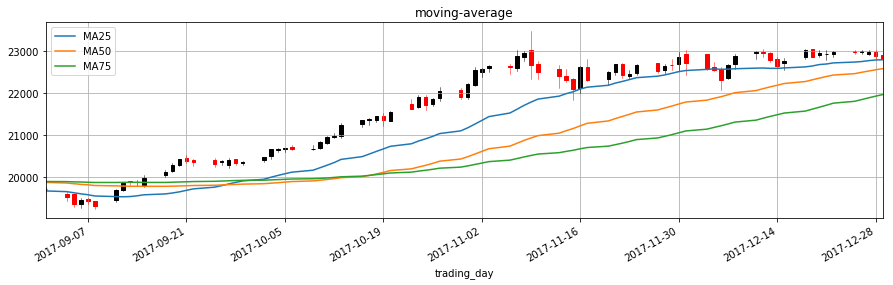

In [38]:
fig = plt.figure(figsize=(15, 4))
ax = plt.subplot()

# ローソク足を作成する関数 
make_candle(candle_start, candle_end, data_candle)

# 移動平均を描画する ------------------------------------------------------------------
data_candle = data[candle_start : candle_end ]
data_candle['MA25'].plot()
data_candle['MA50'].plot()
data_candle['MA75'].plot()
# -----------------------------------------------------------------------------------------

ax.grid() #グリッド表示
ax.set_xlim(data_candle.index[0].date(), data_candle.index[-1].date()) #x軸の範囲
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend()
plt.title('moving-average')

#### ローソク足 ＆ ボリンジャーバンド

Text(0.5,1,'Bolinger-band')

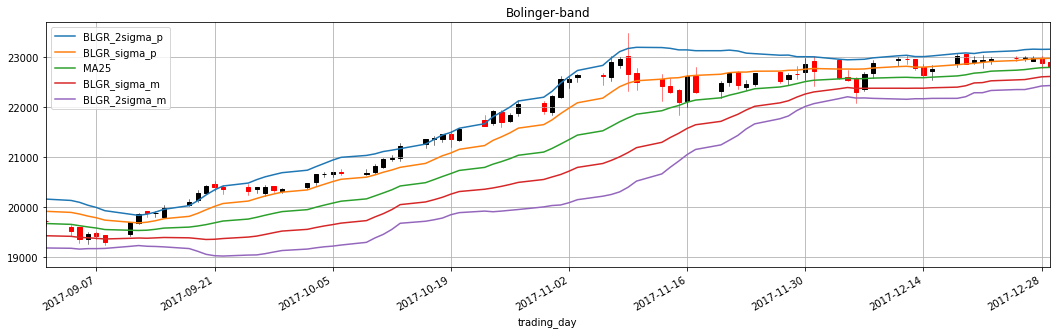

In [39]:
fig = plt.figure(figsize=(18, 5))
ax = plt.subplot()

# ローソク足を作成する関数 
make_candle(candle_start, candle_end, data_candle)

# 移動平均を描画する ------------------------------------------------------------------
data_candle = data[candle_start : candle_end ]
data_candle['BLGR_2sigma_p'].plot()
data_candle['BLGR_sigma_p'].plot()
data_candle['MA25'].plot()
data_candle['BLGR_sigma_m'].plot()
data_candle['BLGR_2sigma_m'].plot()

#data_candle[['price_close', 'MA25', 'BLGR_sigma_p', 'BLGR_2sigma_p', 'BLGR_sigma_m', 'BLGR_2sigma_m']].plot()
# -----------------------------------------------------------------------------------------

ax.grid() #グリッド表示
ax.set_xlim(data_candle.index[0].date(), data_candle.index[-1].date()) #x軸の範囲
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend()
plt.title('Bolinger-band')

### 目的変数

In [40]:
#　目的変数作成ときの上昇値のしきい値
TARGET_LINE_HIGH = 500
TARGET_LINE_LOW = 250

def create_target(x):
    if x.high_max - x.price_close >= TARGET_LINE_HIGH :
        if x.price_close - x.low_min <= TARGET_LINE_LOW:
            return 1
        else :
            return 0
    else :
        return 0

In [41]:
# N+1の高値
data['f1_high'] = data['price_high'].shift(-1)
# N+2の高値
data['f2_high'] = data['price_high'].shift(-2)
# N+3の高値
data['f3_high'] = data['price_high'].shift(-3)
# N+4の高値
data['f4_high'] = data['price_high'].shift(-4)
# N+5の高値
data['f5_high'] = data['price_high'].shift(-5)

# N+1の安値
data['f1_low'] = data['price_low'].shift(-1)
# N+2の高値
data['f2_low'] = data['price_low'].shift(-2)
# N+3の高値
data['f3_low'] = data['price_low'].shift(-3)
# N+4の高値
data['f4_low'] = data['price_low'].shift(-4)
# N+5の高値
data['f5_low'] = data['price_low'].shift(-5)

# 直後５日間の高値で最大のものを選定
data['high_max'] = data[['f1_high', 'f2_high', 'f3_high', 'f4_high', 'f5_high']].max(axis=1)
# 直後５日間の安値で最小のものを選定
data['low_min'] = data[['f1_low', 'f2_low', 'f3_low', 'f4_low', 'f5_low']].min(axis=1)


# 目的変数作成
data['target'] = data.apply(lambda x : create_target(x), axis=1)

data = data.drop(['f1_high', 'f2_high', 'f3_high', 'f4_high', 'f5_high','f1_low', 'f2_low', 'f3_low', 'f4_low', 'f5_low' ], axis=1)
#data = data.drop(['high_max', 'low_min'], axis=1)

In [42]:
def create_diff_high_max(x):
    return x.high_max - x.price_close

def create_diff_low_min(x):
    return x.low_min - x.price_close

In [43]:
# 目的変数作成
data['diff_high_max'] = data.apply(lambda x : create_diff_high_max(x), axis=1)
data['diff_low_min'] = data.apply(lambda x : create_diff_low_min(x), axis=1)

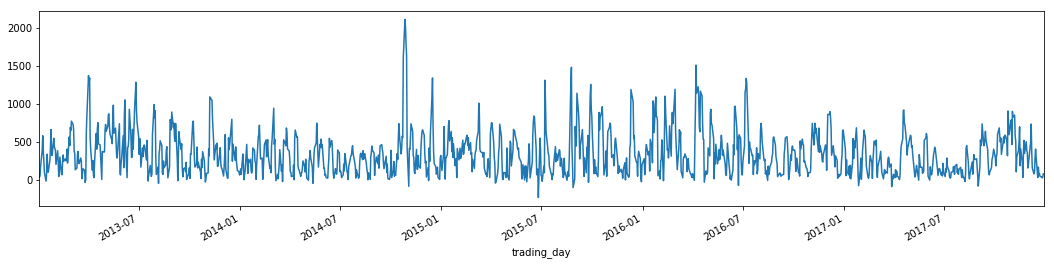

In [44]:
data['diff_high_max'].plot(figsize=(18,4))

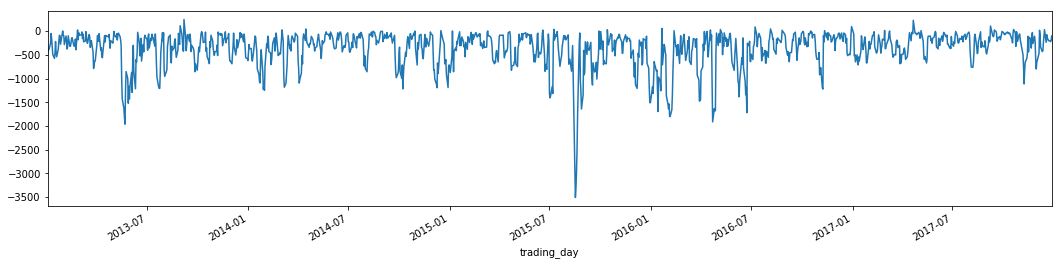

In [850]:
data['diff_low_min'].plot(figsize=(18,4))

### 目的変数を可視化（表示期間を指定）

In [853]:
# ローソク足を描画するする期間を指定
candle_start = '2013-01'
candle_end = '2013-008'
  
#　ローソク足を描画するデータを作成
data_candle = data[candle_start :  candle_end]
data_candle = data_candle[['price_start', 'price_high', 'price_low', 'price_close', 'target']]
data_candle.columns = ['open', 'high', 'low', 'close', 'target']

data_candle['target'] = data_candle['target']* data_candle['low'].min()


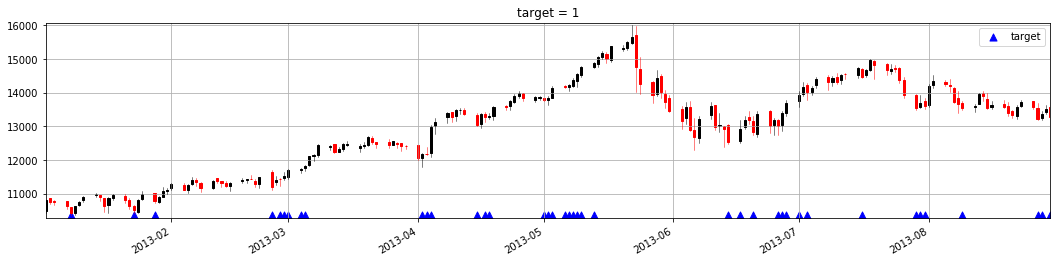

In [854]:
fig = plt.figure(figsize=(18, 4))
ax = plt.subplot()

# ローソク足を作成する関数 
make_candle(candle_start, candle_end, data_candle)
#
plt.scatter(data_candle.index, data_candle['target'], c='blue', s=50, marker='^')

ax.grid() #グリッド表示
ax.set_xlim(data_candle.index[0].date(), data_candle.index[-1].date())                  # x軸の範囲指定
ax.set_ylim([data_candle['low'].min()*0.99, data_candle['high'].max()*1.005]) # y軸の範囲指定
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend()
plt.title('target = 1')
plt.show()

### NaNを含む行を削除

In [45]:
data = data.dropna(axis=0)

### モデルで利用する変数のみに絞る

In [46]:
model_list = ['target',	'wd_Monday',	'wd_Thursday',	'wd_Wednesday',	'wd_Thursday',	'wd_Friday',	'up_flg',	
              'down_flg',	'up_cnt_rolling5_0.0',	'up_cnt_rolling5_1.0',	'up_cnt_rolling5_2.0',	'up_cnt_rolling5_3.0',	
              'up_cnt_rolling5_4.0',	'up_cnt_rolling5_5.0',	'up_must_length',	'down_must_length',	'box_length',	'RCI9_p',
              'RCI9_m',	'RCI9_slope_p',	'RCI9_slope_m',	'RSI',	'RSI_slope',	'cross_25_50_-1',	'cross_25_50_1',	'cross_25_75_-1',
              'cross_25_75_1',	'cross_50_75_-1',	'cross_50_75_1',	'MA25_slope_p',	'MA25_slope_m',	'MA50_slope_p',	'MA50_slope_m',
              'MA75_slope_p',	'MA75_slope_m',	'MA25_dev_p',	'MA25_dev_m',	'BLGR_sigma_p_dev_p',	'BLGR_sigma_p_dev_m',
              'BLGR_2sigma_p_dev_p',	'BLGR_2sigma_p_dev_m',	'BLGR_sigma_m_dev_p',	'BLGR_sigma_m_dev_m',	'BLGR_2sigma_m_dev_p',
              'BLGR_2sigma_m_dev_m',]

data = data[model_list]

In [48]:
data.to_csv('../01.data/02.train/data.csv')

### min-max スケーリング

In [857]:
mms = MinMaxScaler()

In [858]:
# 正規化する値のリスト
minmax_list = ['up_must_length',	'down_must_length',	'box_length',	'RCI9_p',	'RCI9_m',	'RCI9_slope_p',	'RCI9_slope_m',	
               'RSI',	'RSI_slope',	'MA25_slope_p',	'MA25_slope_m',	'MA50_slope_p',	'MA50_slope_m',	'MA75_slope_p',	'MA75_slope_m',	
               'MA25_dev_p',	'MA25_dev_m',	'BLGR_sigma_p_dev_p',	'BLGR_sigma_p_dev_m',	'BLGR_2sigma_p_dev_p',	
               'BLGR_2sigma_p_dev_m',	'BLGR_sigma_m_dev_p',	'BLGR_sigma_m_dev_m',	'BLGR_2sigma_m_dev_p',	'BLGR_2sigma_m_dev_m']
# 正規化実行
data[minmax_list] = mms.fit_transform( data[minmax_list])

### csv書き出し

In [859]:
data.to_csv('../01.data/02.train/data_normalized.csv')